In [25]:
### import numpy as np
import gensim
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot,model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle
import pandas as pd
import numpy as np

In [26]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
vocab_size = len(corpora)
print('Number of words in corpora: %d'%(vocab_size))
tmp = list(corpora.items())

Number of words in corpora: 26


In [27]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

In [28]:
len(text)

30

### Generate words patterns

In [29]:
seq_length = 2

In [30]:
dataX = []
dataY = []

for i in range(0, len(text)-seq_length, 1):
    seq_in = text[i:i+seq_length]
    seq_out = text[i+seq_length]
    dataX.append(seq_in)
    dataY.append(seq_out)

In [31]:
seq_length

2

In [32]:
len(dataX)

28

In [33]:
len(dataY)

28

In [34]:
#dataX, dataY

In [35]:
emb = Embedding(input_dim=vocab_size, output_dim=4, input_length=seq_length)

In [36]:
lstm_1 = LSTM(50)
#lstm_1 = LSTM(50, input_length=seq_lenght)

In [37]:
out_layer = Dense(output_dim=vocab_size, activation='softmax')

In [38]:
model = Sequential(layers=[emb, lstm_1, out_layer])

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 2, 4)          104         embedding_input_2[0][0]          
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 50)            11000       embedding_2[0][0]                
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 26)            1326        lstm_2[0][0]                     
Total params: 12430
____________________________________________________________________________________________________


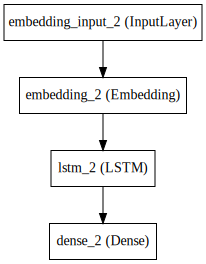

In [41]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [42]:
X = np.reshape(dataX, (len(dataX), seq_length))

In [43]:
X.shape

(28, 2)

In [44]:
y = np_utils.to_categorical(dataY)
y.shape

(28, 26)

In [45]:
filepath="test.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

model.fit(X, y, batch_size=1, nb_epoch=50, callbacks=[checkpoint])

Epoch 1/50
28/28 [==============================] - 0s - loss: 3.2633 - acc: 0.0000e+00     
Epoch 2/50
28/28 [==============================] - 0s - loss: 3.2536 - acc: 0.0714     
Epoch 3/50
28/28 [==============================] - 0s - loss: 3.2477 - acc: 0.1071     
Epoch 4/50
28/28 [==============================] - 0s - loss: 3.2401 - acc: 0.1429     
Epoch 5/50
28/28 [==============================] - 0s - loss: 3.2305 - acc: 0.1429     
Epoch 6/50
28/28 [==============================] - 0s - loss: 3.2186 - acc: 0.2143     
Epoch 7/50
28/28 [==============================] - 0s - loss: 3.2002 - acc: 0.1786     
Epoch 8/50
28/28 [==============================] - 0s - loss: 3.1787 - acc: 0.1429     
Epoch 9/50
28/28 [==============================] - 0s - loss: 3.1429 - acc: 0.2500     
Epoch 10/50
28/28 [==============================] - 0s - loss: 3.0944 - acc: 0.2500     
Epoch 11/50
28/28 [==============================] - 0s - loss: 3.0287 - acc: 0.2857     
Epoch 12/50
28/

In [46]:
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 96.43%


### Test prediction

In [47]:
def get_next(inp):
    idxs = [corpora.token2id[c] for c in inp]
    idxs = np.reshape(idxs, (1, seq_length, 1))
    #idxs = idxs / float(len(corpora))
    prediction = model.predict(idxs, verbose=0)
    index = np.argmax(prediction)
    result = corpora.id2token[index]
    return result

In [59]:
def get_next_emb(inp):
    idxs = [corpora.token2id[c] for c in inp]
    arrs = np.array(idxs)[np.newaxis,:]
    print(np.array(idxs))
    print(arrs)
    p = model.predict(arrs)[0]
    return corpora.id2token[np.argmax(p)]

In [60]:
get_next_emb(['One', 'two'])

[2 0]
[[2 0]]


'three'

In [54]:
test_cases_text = pd.read_csv('./data/test_cases_text.csv')
pred = []
for index, row in test_cases_text.iterrows():
    #print( '%s %s'%(row['in_0'], row['in_1']))
    inp = [row['in_0'], row['in_1']]
    #print(inp)
    tmp = get_next_emb(inp)
    pred.append(tmp)
test_cases_text['predicted'] = pred

In [58]:
test_cases_text[test_cases_text.out!=test_cases_text.predicted]

,in_0,in_1,out,predicted
26,are,you,doing,?


In [56]:
true_cnt = len(test_cases_text[test_cases_text.out==test_cases_text.predicted].index) * 1.0
all_cnt = len(test_cases_text.index) * 1.0
print('True cnt: %d All cnt %d'%(true_cnt, all_cnt))
print("Precision: %.2f"%( true_cnt/all_cnt))

True cnt: 27 All cnt 28
Precision: 0.96
